# Sensitivity Analysis with Custom, Multi-Variate Distributions

Notebook developed by Saman Razavi and Cordell Blanchard

### For the Generalized VARS (G-VARS) method, please cite:

Do, N. C., & Razavi, S. (2020). Correlation effects? A major but often neglected component in sensitivity and uncertainty analysis. Water Resources Research, 56(3), e2019WR025436. https://doi.org/10.1029/2019WR025436

## Exercise 4: SA of the Ishigami test function when inputs follow empirical distributions
### Objective:

This notebook runs a sensitivity analysis when the theoretical distribution of some inputs is unknown or too complex, but a sample from that distribution is available. Here, the standard G-VARS is extended to accommodate any custom, empirical multi-variate distribution.

**Example research question 1:** Suppose you have a model with uncertain parameters, but the distributional properties of the uncertain parameters are unknown.  Instead, a sample of that distribution is available. Which parameters are the dominant controls of model prediction uncertainty?

**Example research question 2:** Suppose you have a machine-learning model already trained to some input-output data taken from some unknown multi-variate distribution. Which inputs (features) to the machine-learning model are the most important ones in generating the model output?

Here, for demonstration purposes, the simple Ishigami test function is used. But to answer the above questions, it can be replaced with any process-based or machine-learning model.


First import the needed libraries, including `GVARS` for G-VARS and the `Model` class for creating a wrapper around the desired model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from varstool import GVARS, Model

### Introduce the Ishigami function for sensitivity analysis

The Ishigami function is a function with three inputs. It is one of the most commonly used functions in the SA literature to test and compare the performance of different SA methods.

In [2]:
def ishigami(x, a=7, b=0.1):
    '''Ishigami test function'''
    # check whether the input x is a dataframe
    
    if not isinstance(x, (pd.core.frame.DataFrame, pd.core.series.Series, np.ndarray, list)):
        raise TypeError('`x` must be of type pandas.DataFrame, numpy.ndarray, pd.Series, or list')
    
    if len(x) > 3:
        raise ValueError('`x` must have only three arguments at a time')
    
    return np.sin(x[0]) + a*(np.sin(x[1])**2) + b*(x[2]**4)*np.sin(x[0])

Wrap the function of interest with the `Model` class.

In [3]:
ishigami_model = Model(ishigami)

Let's run the wrapped function for an arbitrary input and check the output.

In [4]:
x=pd.Series({#name  #value
             'x1'   : 0 ,
             'x2'   : 0 ,
             'x3'   : 0 ,
             })
ishigami_model(x)

0.0

### Set up a G-VARS experiment with custom distributions

Create a G-VARS experiment and set its attributes. Refer to Exercise 4 for a description of general attributes. Here, only the addition of `custom` distributions to the experiment is explained.

***

The distribution type for any input can be set to `custom`. Any custom distribution is non-parametric, and therefore, all the parameters of a custom distribution should be set to `None`. 

G-VARS derives the properties of a custom distribution empirically from a given sample. The user needs to provide a csv file, with each column including sample data for an input with custom distribution. Different columns can have different lengths. This file should be provided as an experiment attribute called `dist_sample_file`.

**A "good-to-know" piece:**

The Weibull-empirical-distribution approach is used in G-VARS to describe the sample distrbution in the analyses. The range of a custom distrbuted input is assumed to be the minimum and maximum of the respective sample.

G-VARS does not estimate the fictive matrix when one or more of the inputs follow custom distributions and assumes it is identical to the original correlation matrix. This is because of numerical inefficiency issues. Therefore, the attribute `fictive_mat_flag` is not accounted for here even if it is included. Our experience, however, shows that this will have minimal impact on sensitivity results.
***

In [5]:
# Define Experiment 3

my_parameters = { 'x1': ( None, None, None, 'custom'),  
                  'x2': ( None, None, None, 'custom'), 
                  'x3': (-3.14, 3.14, None, 'unif'  )}

my_corr_mat = np.array([[ 1   ,  0 ,  0.5 ],
                        [ 0   ,  1 ,  0   ],
                        [ 0.5 ,  0 ,  1   ]])

my_num_dir_samples = 10

my_delta_h = 0.1
# my_delta_h = 1 / my_num_dir_samples # or choose values such as 0.1

experiment_3 = GVARS(parameters      = my_parameters,
                    corr_mat         = my_corr_mat,
                    num_stars        = 100,
                    num_dir_samples  = my_num_dir_samples,
                    delta_h          = my_delta_h,
                    ivars_scales     = (0.1, 0.3, 0.5),
                    sampler          = 'lhs',
                    slice_size       = 10,
                    model            = ishigami_model,
                    seed             = 123456789,
                    bootstrap_flag   = True,
                    bootstrap_size   = 100,
                    bootstrap_ci     = 0.9,
                    grouping_flag    = True,
                    num_grps         = 2,
                    dist_sample_file = '4a - custom_distributions.csv',
                    report_verbose   = True,
                    )

### Run the G-VARS experiments

Now, run the G-VARS experiment set up above.

In [6]:
experiment_3.run_online()

generating star points
:   0%|                                                                   | 0/8 [00:00<…

model evaluation:   0%|                                                                       | 0/2999 [00:00<…

building pairs:   0%|                                                                          | 0/300 [00:00<…

calculating 'h' values:   0%|          | 0/100 [00:00<?, ?it/s]

binning and reording pairs based on 'h' values:   0%|          | 0/100 [00:00<?, ?it/s]

GVARS analysis:   0%|                                                                           | 0/10 [00:00<…

factor ranking:   0%|                                                                            | 0/2 [00:00<…

bootstrapping and grouping:   0%|                                                              | 0/100 [00:00<…

### Check out the results

When the G-VARS analysis is completed, let's check out the results of sensitivity analysis.

**IVARS: Integrated variogram Across a Range of Scales** 

IVARS indices are the primary sensitivity indices by the VARS approach. First, print all the IVARS indices for the scale ranges of interest.

In [7]:
# IVARS from Experiment 3
cols = experiment_3.parameters.keys()
experiment_3.ivars[cols]

,x1,x2,x3
0.1,0.022289,0.055215,0.068549
0.3,0.411321,0.941967,0.687890
0.5,1.053456,2.250386,1.900041


 Choose a scale range and plot the respective IVARS indices. Two points:
 
    POINT1: IVARS-50 (h=[0-0.5]), called ***Total-Variogram Effect*** is the most comprehensive sensitivity index.
    POINT2: Plotting sensitivity results in log scale helps us better differentiate less influential parameters.

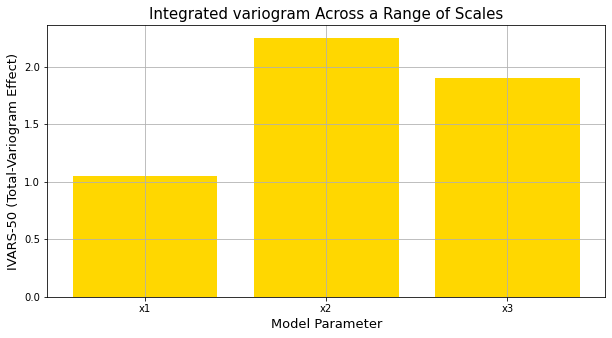

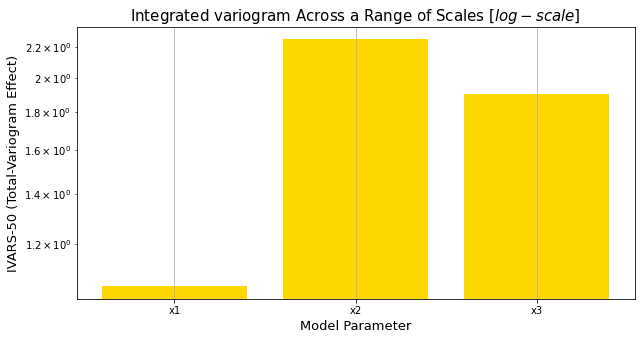

In [8]:
# Plot IVARS from Experiment 3
ivars_scale = 0.5 # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_3.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.ivars.loc[pd.IndexSlice[ ivars_scale ]][cols], color='gold')
plt.gca().set_title (r'Integrated variogram Across a Range of Scales', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.ivars.loc[pd.IndexSlice[ ivars_scale ]][cols], color='gold')
plt.gca().set_title (r'Integrated variogram Across a Range of Scales $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('log')

**VARS-TO: Sobol Total-Order Effect** 

In addition to the IVARS indices, VARS and G-VARS estimate Sobol variance-based total-order effects as side products. Below, print them and plot them.

In [9]:
# VARS-TO from Experiment 3
cols = experiment_3.parameters.keys()
experiment_3.st.to_frame().T[cols]

param,x1,x2,x3
0,0.130543,0.26068,0.367732


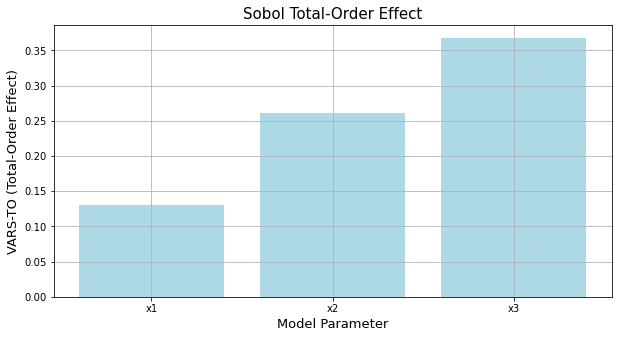

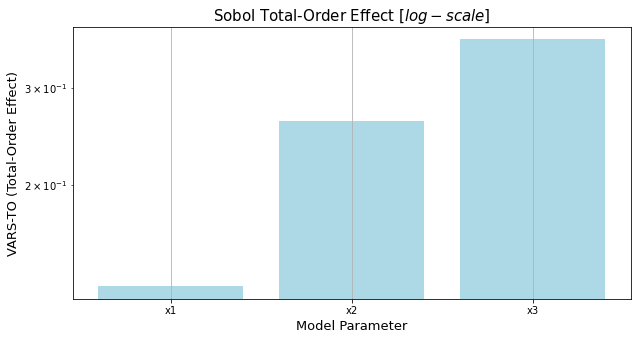

In [10]:
# Plot VARS-TO from Experiment 3
cols = experiment_3.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.st.to_frame().T.iloc[0][cols], color='lightblue')
plt.gca().set_title (r'Sobol Total-Order Effect', fontsize = 15)
plt.gca().set_ylabel(r'VARS-TO (Total-Order Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_3.st.to_frame().T.iloc[0][cols], color='lightblue')
plt.gca().set_title (r'Sobol Total-Order Effect $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'VARS-TO (Total-Order Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('log')

**Directional Variograms - γ(h)** 

For advanced users of VARS, directional variograms may provide a wealth of information about the structure of the model response surface.

    POINT: Variograms are most meaningful when h (perturbation scale) is between zero and 0.5 of the parameter ranges, but the user can investigate the entire perturbation range (0 – 1).
    
 Below, print the directional variograms and then plot them.

In [11]:
# Directional Variograms from Experiment 3
cols = experiment_3.parameters.keys()                     
variograms = experiment_3.gamma.unstack(0)[cols].copy()
variograms

param,x1,x2,x3
h,,,
0.025,0.029569,0.101427,0.172798
0.100,0.445781,1.104292,1.370974
0.200,2.341175,4.232309,2.982617
0.300,2.652501,8.166134,5.050618
0.400,3.983488,7.838182,6.207131
0.500,2.223233,2.325887,6.778140
0.600,0.257970,1.141434,10.429349
0.700,0.307794,2.616182,10.500378
0.800,NaN,4.796347,7.979668


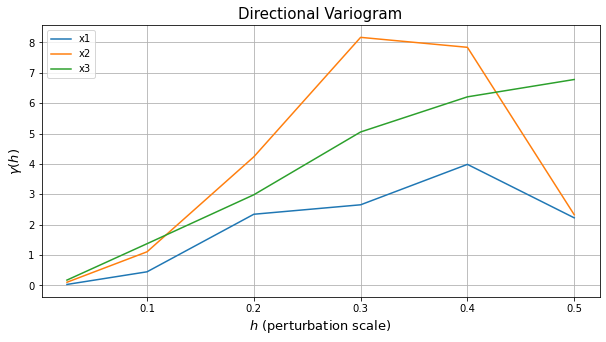

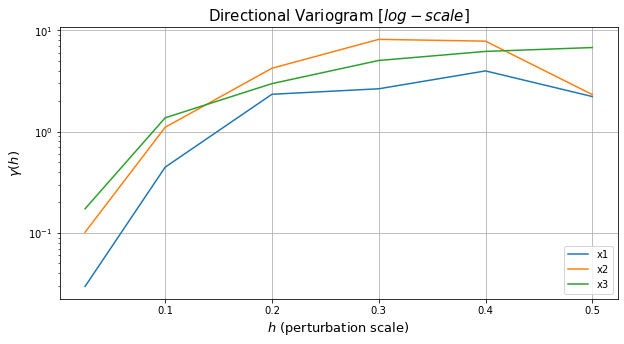

In [12]:
# Plot Directional Variograms from Experiment 3

plotting_scale = 0.5 # any number between delta_h and one.

matrix_y = variograms.loc[variograms.index <= plotting_scale].to_numpy()
column_x = variograms.loc[variograms.index <= plotting_scale].index.to_numpy()
matrix_x = np.tile(column_x, (matrix_y.shape[1], 1)).T

fig_cdf = plt.figure(figsize=(10,5))
plt.gca().plot(matrix_x, matrix_y )
plt.gca().set_title (r'Directional Variogram', fontsize = 15)
plt.gca().set_ylabel(r'$γ(h)$', fontsize = 13)
plt.gca().set_xlabel(r'$h$ (perturbation scale)', fontsize=13)
plt.gca().set_yscale('linear')
plt.gca().legend (cols, loc='upper left', fontsize = 10)
plt.gca().grid()

fig_cdf = plt.figure(figsize=(10,5))
plt.gca().plot(matrix_x, matrix_y )
plt.gca().set_title (r'Directional Variogram $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'$γ(h)$', fontsize = 13)
plt.gca().set_xlabel(r'$h$ (perturbation scale)', fontsize=13)
plt.gca().set_yscale('log')
plt.gca().legend (cols, loc='lower right', fontsize = 10)
plt.gca().grid()

**Cross sections of sample points in the input space**

Choose any pair of parameters and see the projection of all star centers and star points onto the respective two-dimensional space.

<AxesSubplot:title={'center':'Star Points'}, xlabel='x2', ylabel='x3'>

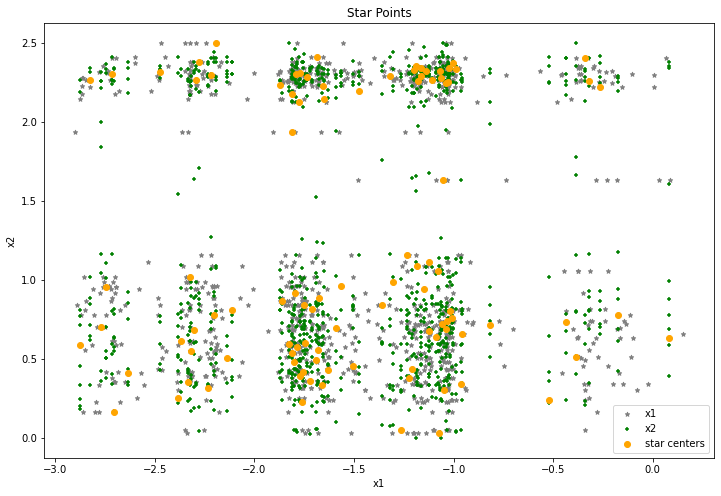

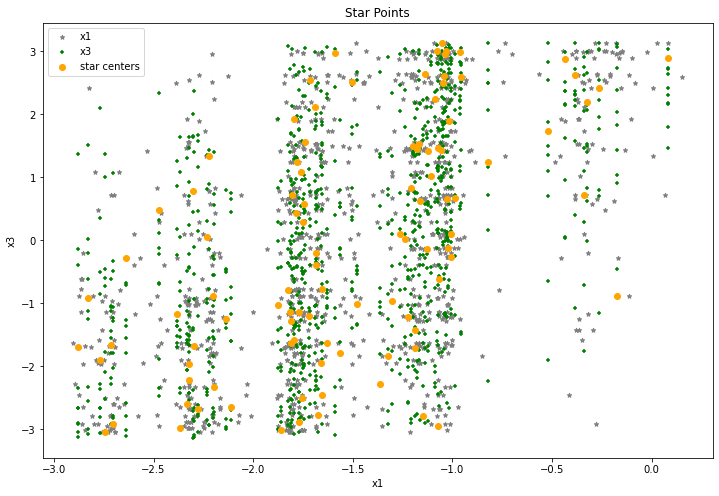

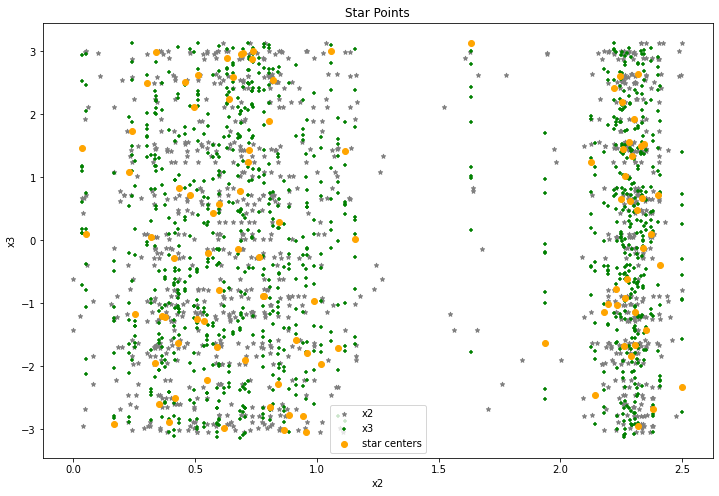

In [13]:
experiment_3.correlation_plot(param_names=['x1', 'x2'])
experiment_3.correlation_plot(param_names=['x1', 'x3'])
experiment_3.correlation_plot(param_names=['x2', 'x3'])

**Star centers used in the G-VARS experiment**

The following dataframe includes all the star centers generated.

In [14]:
# Star centers generated in Experiment 3
cols = experiment_3.parameters.keys()
pd.DataFrame(data=experiment_3.star_centres, columns=cols)

,x1,x2,x3
0,-1.628390,0.427816,-1.626610
1,-1.859256,0.866370,-3.009808
2,-1.122435,1.114288,1.424192
3,-2.768419,0.703711,-1.906714
4,-1.761038,0.227901,1.088707
...,...,...,...
95,-1.770453,0.393898,-2.885654
96,-0.819600,0.715196,1.239380
97,-1.089554,0.641003,2.247697
98,-2.369260,0.616685,-2.985322


**Star points generated along with respective outputs**

The following dataframe includes all the star points generated. For each row, the first column indicates the associated star center, the second column indicates the parameter along which the cross-sectional samples were taken, and the third column indicates the star point numbers along that cross section. The last column indicates the evaluated model response (output) for the input set in each row.

In [15]:
# Star points generated in Experiment 3
experiment_3.model_df

x1        x2        x3  ishigami
centre param points                                        
0      x1    0      -2.331852  0.427816 -1.626610 -0.026121
             1      -1.182266  0.427816 -1.626610 -0.368441
             2      -1.765678  0.427816 -1.626610 -0.462971
             3      -1.506564  0.427816 -1.626610 -0.491646
             4      -2.464229  0.427816 -1.626610  0.139409
...                       ...       ...       ...       ...
99     x3    5      -2.279282  2.379424 -1.207357  2.416747
             6      -2.279282  2.379424  0.145616  2.578068
             7      -2.279282  2.379424  1.674545  1.981028
             8      -2.279282  2.379424 -2.793242 -2.044380
             9      -2.279282  2.379424 -2.610510 -0.948382

[3000 rows x 4 columns]

**Pairs generated and their associated dissimilarity**

The following dataframe includes all the resulting pairs of samples. For each row, the first column indicates the associated star center and the second column indicates the parameter along which the cross-sectional samples were taken.
The `pair_ind` column indicates the index of sample points in each pair, the `h` column indicates the binned distance between the two samples in each pair, and the `actual h` column indicates the exact distance between the two. The columns `0` and `1` show the outputs [y1 and y2] associated with each sample points in the pair. The `dissimilarity` column shows 0.5[y1-y2]^2.

In [16]:
# all pairs generated in Experiment 3
experiment_3.pair_df

0         1  dissimilarity
centre param h     actual h pair_ind                                   
0      x1    0.025 0.032287 (0, 4)   -0.026121  0.139409       0.013700
                   0.008374 (1, 5)   -0.368441 -0.345408       0.000265
                   0.031215 (0, 8)   -0.026121 -0.165705       0.009742
                   0.014711 (2, 6)   -0.462971 -0.440093       0.000262
                   0.035900 (1, 7)   -0.368441 -0.256976       0.006212
...                                        ...       ...            ...
99     x3    0.700 0.711431 (7, 8)    1.981028 -2.044380       8.101955
                   0.666043 (1, 9)    2.114102 -0.948382       4.689405
                   0.682334 (7, 9)    1.981028 -0.948382       4.290722
                   0.704770 (0, 7)   -1.773651  1.981028       7.048807
             0.800 0.750130 (2, 7)   -3.875533  1.981028      17.149654

[13500 rows x 3 columns]

All done!